# Noise2Voidの実装をする

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='3,4,5'

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torchvision
import visdom

import numpy as np
import matplotlib.pyplot as plt

import cv2
import glob
import random

from src import unet
from src.utils.progressbar import progressbar

## Dataの確認

Grand truthのデータは, origin_picの下にあって、noised_dataはnoised_picに入っている。   

## Dataset

In [2]:
# datasetを作る
class Noise2VoidDataset(Dataset):
    
    def __init__(self, pic, virtural_datasize=1000,crop_size=None, gauss_std=1,transform=None, valid=False):
        super(Noise2VoidDataset, self).__init__()
        self.img = cv2.cvtColor(cv2.imread(pic), cv2.COLOR_BGR2RGB)
        self.crop_size = crop_size
        self.noise_std = gauss_std
        self.transform = transform
        self.valid = valid
        
        self.noised_img = self._add_noise(self.img)
        self.noised_imgs =[]
        if valid:
            self.origin_imgs = []
            
        for i in range(virtural_datasize):
            if crop_size is not None:
                cropped_noisy_img, cropped_origin_img = self._random_crop([self.noised_img, self.img])
            else:
                cropped_noisy_img, cropped_origin_img = self.noised_img, self.img
            self.noised_imgs.append(cropped_noisy_img)
            if valid:
                self.origin_imgs.append(cropped_origin_img)
        
    def __getitem__(self,index):
        source = self.noised_imgs[index]
        source = torch.tensor(source,dtype=torch.float)
        source, target, blind_pos = self._mask_pixel(source)
        
        if self.valid:
            target =  torch.tensor(self.origin_imgs[index],dtype=torch.float)
        
        if self.transform:
            source = self.transform(source)
            target = self.transform(target)
        
        return source.permute(2,0,1), target.permute(2,0,1), torch.tensor(blind_pos)
    
    def __len__(self):
        return len(self.noised_imgs)
    
    def _add_noise(self, img):
        h,w,c = img.shape
        Noise = np.random.normal(0,self.noise_std, (h,w,c))
        noise_img = np.clip(img + Noise, 0, 255).astype(np.uint8)
        return noise_img
        
    def _random_crop(self, imgs):
        h, w, _  = imgs[0].shape
        assert w >= self.crop_size and h >= self.crop_size, 'Error: Crop size:{self.crop_size} is learger than Image size: ({w},{h})'
        i = np.random.randint(0, h - self.crop_size +1)
        j = np.random.randint(0, w - self.crop_size +1)
        return self._crop(imgs[0], i, j, self.crop_size, self.crop_size), self._crop(imgs[1], i, j, self.crop_size, self.crop_size) 
        
    def _crop(self,img, i, j, h, w):
        """Crop the given image.
        Args:
            img (numpy array): Image to be cropped.
            i (int): i in (i,j) i.e coordinates of the upper left corner.
            j (int): j in (i,j) i.e coordinates of the upper left corner.
            h (int): Height of the cropped image.
            w (int): Width of the cropped image.
        Returns:
            Image: Cropped image.
        """
        return img[i:i+h,j:j+w,:]
    
    def _mask_pixel(self, img):
        '''
        a randomly selected pixel is chosen and its intensity copied over to create a blind-spot.
        '''
        h,w,_ = img.shape
        random_select_pixel_i = np.random.randint(0, h)
        random_select_pixel_j = np.random.randint(0, w)
        blind_spot_i = np.random.randint(0, h)
        while blind_spot_i==random_select_pixel_i:
            blind_spot_i = np.random.randint(0, h)
            
        blind_spot_j = np.random.randint(0, w)
        while blind_spot_j==random_select_pixel_j:
            blind_spot_j = np.random.randint(0, w)
            
        target = img.clone()
        source = img.clone()
        source[blind_spot_i, blind_spot_j, :] = img[random_select_pixel_i, random_select_pixel_j, :]
        return source, target, [blind_spot_i, blind_spot_j]
        
def normalize(x):
    return x.div(255)

def denormalize(x):
    return np.clip(x.mul(255),0,255).type(torch.int)

In [3]:
def pixel_mse_loss(predictions, targets, pixel_pos):
    mask = torch.zeros(targets.shape).to(targets.device)
    for i,(h,w) in enumerate(pixel_pos):
        mask[i,:,h,w] = 1.
    return F.mse_loss(predictions*mask, targets*mask)*1000

In [7]:
def save_model_parameters(model,savedir, loss, loss_min, epoch,save_per_epoch=True):
    if not os.path.exists(savedir):
        os.makedirs(savedir)      
            
    try:
        state_dict = model.module.state_dict()
    except AttributeError:
        state_dict = model.state_dict()
    
    if (epoch == 0) or (loss_min > loss):
        loss_min = loss
        torch.save(state_dict, os.path.join(savedir,'best.pth'))
    if save_per_epoch:
        torch.save(state_dict, os.path.join(savedir,'epoch{0}.pth'.format(epoch)))
    
    return loss_min
    
def visualize_losses(losses, epoch, legends, title, window_name,env_name):
    viz = visdom.Visdom(env=env_name)
    viz.line(X=[epoch],Y=[losses[-1]],opts=dict(legend=legends, title=title), win=window_name, update='append')

## ネットワークを作る

## 学習モデル

In [58]:
def train():
    #model
    model = unet.UNet(3,3,depth=4,batch_norm=True,up_mode='upsample',padding=True)
    if torch.cuda.is_available():
        model = nn.DataParallel(model)
        model = model.to('cuda')
    
    #dataset
    noised_dataset = Noise2VoidDataset(pic='./data/train/000000000632.jpg', virtural_datasize=10000,crop_size=64, gauss_std=50,transform=normalize)
    train_loader = DataLoader(noised_dataset, batch_size=100, shuffle=True,num_workers=2)
    valid_dataset = Noise2VoidDataset(pic='./data/train/000000000632.jpg', virtural_datasize=100,crop_size=64, gauss_std=50,transform=normalize,valid=True)
    valid_loader = DataLoader(valid_dataset, batch_size=20, shuffle=True,num_workers=2)
    
    #TRAIN MODEL
    #mini batch training
    #optimizer
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    #     lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100], gamma=0.1)
    
    
    N_epoch = 50
    loss_history = []
    loss_min = np.inf

    prog = progressbar.progbar(N_epoch,display='notebook',clear_display=True)
    for epoch in range(N_epoch):
        loss_train = train_per_epoch(train_loader,model,optimizer,loss_function=pixel_mse_loss)
        loss_valid = valid_per_epoch(valid_loader,model,loss_function=pixel_mse_loss)
        
        #         lr_scheduler.step()
    
        loss_history.append([loss_train, loss_valid])    
        loss_min = save_model_parameters(
            model,
            savedir='./stored/Noise2Void/',
            loss=loss_valid,
            loss_min=loss_min,
            epoch=epoch,
            save_per_epoch=True)
        
        visualize_losses(
            losses=np.array(loss_history),
            epoch=epoch, 
            legends=['train', 'valid'], 
            title='Noise2Noise',
            window_name='Noise2Void', 
            env_name='Noise2Void')
        
        prog.update(epoch)
    del prog
    
    
def train_per_epoch(train_loader, model, optimizer, loss_function):
    model.train()
    
    N_batch = len(train_loader)
    running_loss = []
    prob_tr = progressbar.progbar(N_batch,display='notebook',clear_display=False)
    for batch_idx,(sources,targets,pixel_pos) in enumerate(train_loader):
        if torch.cuda.is_available():
            sources,targets = sources.to('cuda'), targets.to('cuda')
            
        predicts = model(sources)
        loss = loss_function(predicts, targets,pixel_pos)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss.append(loss.item())
        
        if (batch_idx%10 == 0) or (batch_idx==0) or (batch_idx==N_batch-1):
            prob_tr.update(
                batch_idx,
                info='train batch:{0}/{1}, loss:{2}'.format(batch_idx,N_batch,loss.item()))
    del prob_tr
    return np.mean(running_loss)    
    
def valid_per_epoch(valid_loader, model, loss_function):
    model.eval()
    
    running_loss = []
    prob_vl = progressbar.progbar(len(valid_loader), display='notebook', clear_display=False)
    with torch.no_grad():
        for batch_idx, (sources, targets, pixel_pos) in enumerate(valid_loader):
            if torch.cuda.is_available():
                sources, targets = sources.to('cuda'), targets.to('cuda')
            
            predicts = model(sources)
            loss = loss_function(predicts, targets, pixel_pos)
            
            running_loss.append(loss.item())
            if (batch_idx%20 == 0) or (batch_idx==0) or (batch_idx==len(valid_loader)-1):
                prob_vl.update(
                    batch_idx,
                    info='train batch:{0}/{1}, loss:{2}'.format(batch_idx,len(valid_loader),loss.item()))
    del prob_vl
    return np.mean(running_loss)    

In [59]:
train()

'    100% |################################| 0day  0:00:00 Total time: 0day  0:09:54'

# Test

modelの読み込み

In [60]:
model = unet.UNet(3,3,depth=4,batch_norm=True,up_mode='upsample',padding=True)
if torch.cuda.is_available():
    model = model.to('cuda')
model.load_state_dict(torch.load('./stored/Noise2Void/best.pth'))
model.eval()

UNet(
  (down_path): ModuleList(
    (0): UNetConvBlock(
      (block): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): ReLU()
        (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): UNetConvBlock(
      (block): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): ReLU()
        (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): UNetConvBlock(
      (block): Sequential(
        (0): C

In [86]:
eval_dataset = Noise2VoidDataset(pic='./data/train/000000000632.jpg', virtural_datasize=100,crop_size=None, gauss_std=50,transform=normalize,valid=True)

In [87]:
source, target, pos = eval_dataset[0]

In [88]:
with torch.no_grad():
    predict = model(source.unsqueeze(0).to('cuda')).to('cpu').squeeze()

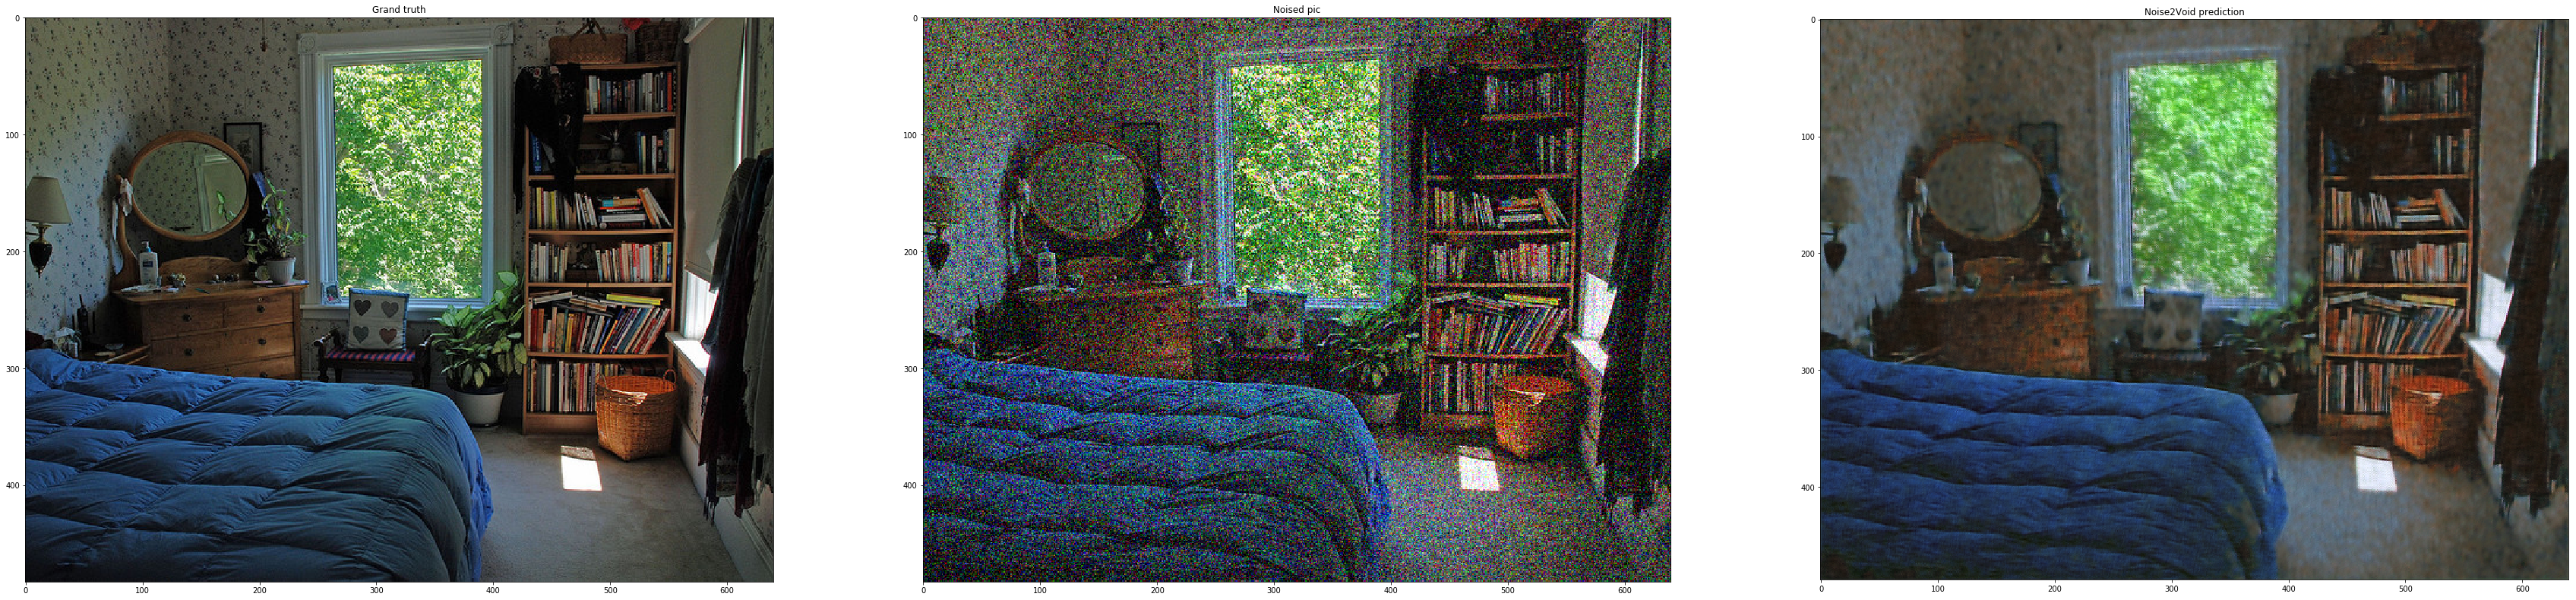

In [89]:
plt.figure(figsize=[60,20])
plt.subplot(1,3,1)
plt.title('Grand truth')
plt.imshow(denormalize(target.permute(1,2,0)))
plt.subplot(1,3,2)
plt.title('Noised pic')
plt.imshow(denormalize(source.permute(1,2,0)))
plt.subplot(1,3,3)
plt.title('Noise2Void prediction')
plt.imshow(denormalize(predict.permute(1,2,0)))
plt.show()

それなりのデノイズされた画像を手に入れられた。    